In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import warnings
from skimpy import skim 
from sklearn.impute import KNNImputer, SimpleImputer
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train_data = pd.read_csv("training.csv")
test_data = pd.read_csv("test.csv")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [5]:
#check for null values

for column, count in train_data.isna().sum()[train_data.isna().sum()>0].items():
    print(f"{column}: {count}") 

patient_race: 6385
payer_type: 1803
patient_state: 51
bmi: 8965
metastatic_first_novel_treatment: 12882
metastatic_first_novel_treatment_type: 12882
Region: 52
Division: 52
population: 1
density: 1
age_median: 1
age_under_10: 1
age_10_to_19: 1
age_20s: 1
age_30s: 1
age_40s: 1
age_50s: 1
age_60s: 1
age_70s: 1
age_over_80: 1
male: 1
female: 1
married: 1
divorced: 1
never_married: 1
widowed: 1
family_size: 4
family_dual_income: 4
income_household_median: 4
income_household_under_5: 4
income_household_5_to_10: 4
income_household_10_to_15: 4
income_household_15_to_20: 4
income_household_20_to_25: 4
income_household_25_to_35: 4
income_household_35_to_50: 4
income_household_50_to_75: 4
income_household_75_to_100: 4
income_household_100_to_150: 4
income_household_150_over: 4
income_household_six_figure: 4
income_individual_median: 1
home_ownership: 4
housing_units: 1
home_value: 4
rent_median: 4
rent_burden: 4
education_less_highschool: 1
education_highschool: 1
education_some_college: 1
educa

In [6]:
display('train data', train_data.head())
display('test data', test_data.head())

'train data'

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


'test data'

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,White,MEDICAID,IN,467,54,F,NaN,C50412,Malig neoplasm of upper-outer quadrant of left...,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,NaN,COMMERCIAL,FL,337,52,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,Hispanic,MEDICAID,CA,917,61,F,NaN,C50911,Malignant neoplasm of unsp site of right femal...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,Hispanic,MEDICARE ADVANTAGE,CA,917,64,F,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,687972,Black,NaN,CA,900,40,F,23.0,C50412,Malig neoplasm of upper-outer quadrant of left...,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261


In [7]:
train_data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
patient_id,12906.000000,547381.196033,260404.959974,100063.000000,321517.000000,543522.000000,772671.750000,999896.000000
patient_zip3,12906.000000,573.754300,275.447534,101.000000,331.000000,554.000000,846.000000,999.000000
patient_age,12906.000000,59.183326,13.335216,18.000000,50.000000,59.000000,67.000000,91.000000
bmi,3941.000000,28.984539,5.696906,14.000000,24.660000,28.190000,32.920000,85.000000
population,12905.000000,20744.441237,13886.903756,635.545455,9463.896552,19154.190480,30021.278690,71374.131580
density,12905.000000,1581.950419,2966.305306,0.916667,171.857143,700.337500,1666.515385,21172.000000
age_median,12905.000000,40.502259,4.036963,20.600000,37.129825,40.639344,42.934783,54.570000
age_under_10,12905.000000,11.122784,1.512376,0.000000,10.160000,11.039216,12.190000,17.675000
age_10_to_19,12905.000000,12.945265,1.923974,6.314286,11.741176,12.923944,14.019767,35.300000
age_20s,12905.000000,13.290376,3.354103,5.925000,11.013415,12.538095,14.971053,62.100000


**STATS**

*Demographic  Information:* 
1. The mean age of male is 50.095180 which slightly  exceeds the female average at 49.904900
2. The mean of married is 47.680767 which greatly exceeds the divorced at 12.670532
3. The average of never_married exceeds greatly the widowed

*Economic Overview:*

1. Median household income is 74,374.37 dollars, and 32.55 % of households fall into the six-figure income bracket.
2. Homeownership rate is 65.99% , and housing values vary, with a median of 339,817.16 dollars

*Education:*

1. 31.53% hold college education and 43.39% holds stem degree
2. Labor force partcipation 61.62%

*Environmental Factors:*

1. Health-related features include an average ozone level of 39.82, a 5.95% unemployment rate, and an 8.58% uninsured rate.
2. Environmental indicators like PM25 and N02 levels are within expected ranges.

*Community Characteristics:*

1. Community attributes encompass racial diversity, with 69.72% White, 11.45% Black, and 5.47% Asian. The Hispanic population constitutes 18.46%.
2. Commute time averages 27.98 minutes, and 13.34% of the population reports having a disability.


In [8]:
train_data.describe(include=['object']).T.style.background_gradient()

,count,unique,top,freq
patient_race,6521,5,White,3588
payer_type,11103,3,COMMERCIAL,6032
patient_state,12855,50,CA,2438
patient_gender,12906,1,F,12906
breast_cancer_diagnosis_code,12906,50,1749,1982
breast_cancer_diagnosis_desc,12906,50,"Malignant neoplasm of breast (female), unspecified",1982
metastatic_cancer_diagnosis_code,12906,43,C773,7052
metastatic_first_novel_treatment,24,2,PEMBROLIZUMAB,13
metastatic_first_novel_treatment_type,24,1,Antineoplastics,24
Region,12854,4,South,3919


1. Patient race has a unique value of 5, *White* being the top with a frequency of 3588
2. Payer type has a 3 unique values with *COMMERCIAL* as the dominant
3. There are 50 Patient_States with top being *CA*
4. The patient gender is *Female* only
5. The most dominant region is *South* while division being *East North Central*

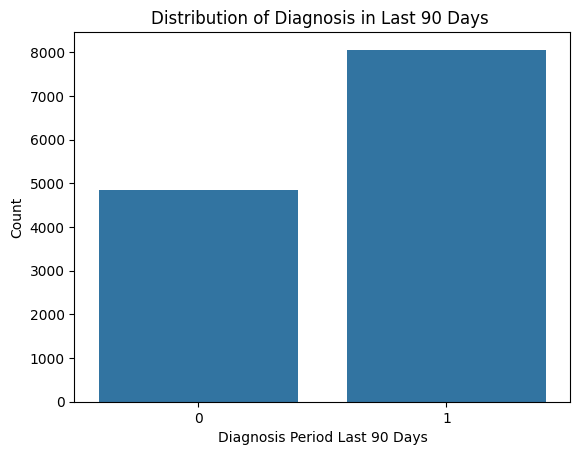

DiagPeriodL90D
1    0.624516
0    0.375484
Name: proportion, dtype: float64

In [9]:
#exploring our target

sns.countplot(data = train_data, x = "DiagPeriodL90D")
plt.title("Distribution of Diagnosis in Last 90 Days ")
plt.ylabel("Count")
plt.xlabel("Diagnosis Period Last 90 Days")
plt.show();
train_data['DiagPeriodL90D'].value_counts(normalize=True)

1 represents patients with a Diagnosis Period Less Than 90 Days and 0 represents patients with a Diagnosis Period Equal To or Greater Than 90 Days.

The value 0.624516 indicates that approximately 62.45% of the patients in the dataset have a Diagnosis Period Less Than 90 Days.

The value 0.375484 indicates that approximately 37.55% of the patients in the dataset have a Diagnosis Period Equal To or Greater Than 90 Days.

**DATA PROCESSING**

In [10]:
#check for the null values

missing_vals = train_data.isnull().sum().sum()
full_data = train_data.size
null_values = 100*(missing_vals/full_data)
print("The missing values are {} constituing of {}% of the whole data".format(missing_vals, null_values))

The missing values are 43292 constituing of 4.041456388081381% of the whole data


In [11]:
# check the null values in each ctegorical column using this skim function
skim(train_data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 12906  │ │ float64     │ 68    │                                                          │
│ │ Number of columns │ 83     │ │ string      │ 11    │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 4     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ patient_id         │    0 │     0 │ 550000 │ 260000 │ 100000 │ 320000 │ 540000 │ 770000 │ 1000000 │ ▇▇▇▇▇▇ │  │
│ │ patient_zip3       │    0 │     0 │    570 │    280 │    100 │    330 │    550 │    850 │    1000 │ ▅▅▆▃▅▇ │  │
│ │ patient_age        │    0 │     0 │     59 │     13 │     18 │     50 │     59 │     67 │      91 │  ▂▅▇▃▂ │  │
│ │ bmi                │ 8965 │ 69.46 │     29 │    5.7 │     14 │     25 │     28 │     33 │      85 │  ▅▇▁   │  │
│ │ population         │    1 │  0.01 │  21000 │  14000 │    640 │   9500 │  19000 │  30000 │   71000 │ ▇▇▅▂▁  │  │
│ │ density            │    1 │  0.01 │   1600 │   3000 │   0.92 │    170 │    700 │   1700 │   21000 │   ▇▁   │  │
│ │ age_median         │    1 │  0.01 │     41 │      4 │     21 │     37 │     41 │     43 │      55 │   ▅▇▃▁ │  │
│ │ age_under_10       │    1 │  0.01 │     11 │    1.5 │      0 │     10 │     11 │     12 │      18 │   ▁▇▅  │  │
│ │ age_10_to_19       │    1 │  0.01 │     13 │    1.9 │    6.3 │     12 │     13 │     14 │      35 │   ▁▇   │  │
│ │ age_20s            │    1 │  0.01 │     13 │    3.4 │    5.9 │     11 │     13 │     15 │      62 │   ▇▂   │  │
│ │ age_30s            │    1 │  0.01 │     13 │    2.3 │    1.5 │     11 │     12 │     14 │      25 │    ▇▃  │  │
│ │ age_40s            │    1 │  0.01 │     12 │    1.2 │    0.8 │     11 │     12 │     13 │      18 │    ▇▇  │  │
│ │ age_50s            │    1 │  0.01 │     13 │    1.6 │      0 │     12 │     14 │     15 │      22 │   ▁▇▃  │  │
│ │ age_60s            │    1 │  0.01 │     13 │    2.6 │    0.2 │     11 │     13 │     14 │      30 │   ▂▇▂  │  │
│ │ age_70s            │    1 │  0.01 │    7.7 │    2.1 │      0 │      6 │    7.3 │    8.8 │      19 │   ▅▇▂  │  │
│ │ age_over_80        │    1 │  0.01 │      4 │    1.2 │      0 │    3.3 │    3.8 │    4.5 │      19 │   ▂▇   │  │
│ │ male               │    1 │  0.01 │     50 │    1.7 │     40 │     49 │     50 │     51 │      62 │    ▇▃  │  │
│ │ female             │    1 │  0.01 │     50 │    1.7 │     38 │     49 │     50 │     51 │      60 │    ▃▇  │  │
│ │ married            │    1 │  0.01 │     48 │    7.5 │    0.9 │     43 │     49 │     53 │      67 │   ▁▃▇▂ │  │
│ │ divorced           │    1 │  0.01 │     13 │      2 │    0.2 │     11 │     13 │     14 │      20 │   ▂▇▆  │  │
│ │ never_married      │    1 │  0.01 │     34 │      8 │     13 │     28 │     32 │     39 │      99 │  ▃▇▂   │  │
│ │ widowed            │    1 │  0.01 │    5.8 │    1.5 

In [12]:
#find the total number of missing values
miss_vals = train_data.isnull().sum()

#calc the percentages of miss values for each column and change the values to Series
missing_percentages = pd.Series(missing_vals/len(train_data))*100


In [13]:
#lets sort them in order(desc)
sorted_columns = missing_percentages.sort_values(ascending=False).index

In [14]:
#iterate and print the result
for column in sorted_columns:
    missing_values = miss_vals[column]
    #calc the percentages of miss values for each column and change the values to Series
    missing_percentages = missing_percentages[column]
    
    print("The missing values of {} is {} which is {}% of column data".format(column, miss_vals, round(missing_percentages, 2)))

The missing values of 0 is patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64 which is 335.44% of column data


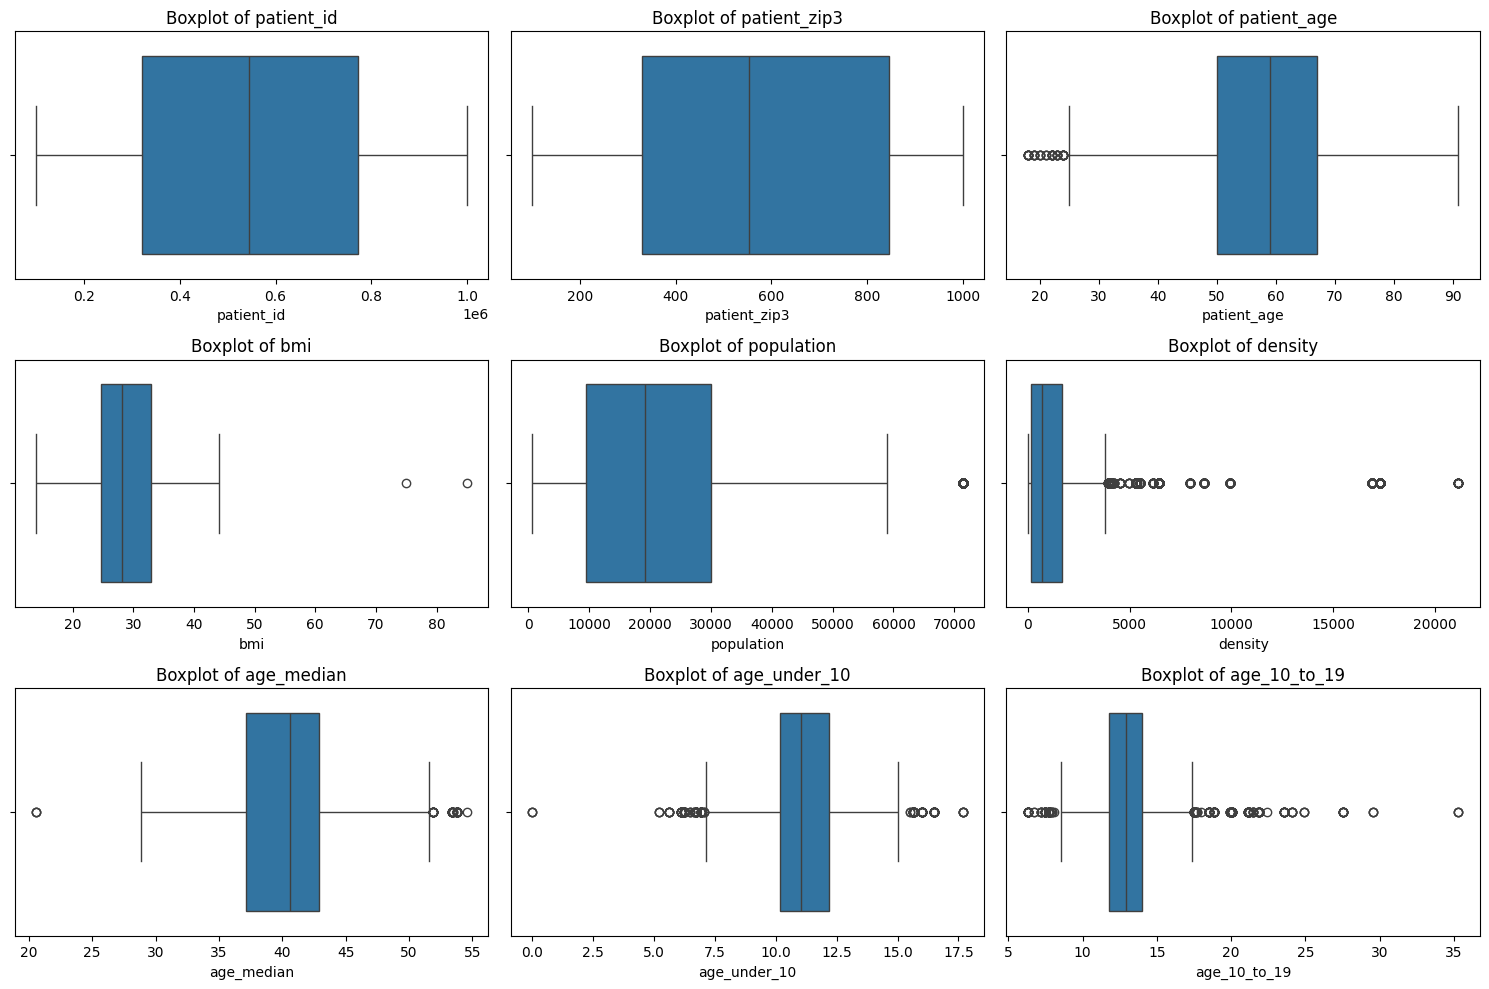

In [15]:
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
num_cols = len(numerical_columns)
num_subplots = min(num_cols, 9)  # Maximum 9 subplots

for i, column in enumerate(numerical_columns[:num_subplots], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_data[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show();

**HANDLING MISSING VALUES**

To do this, we use the KNN imputation technique

In [16]:
zero_counts = (train_data == 0).sum()


columns_with_zeros = zero_counts[zero_counts > 0]
print("Columns with counts of 0:")
print(columns_with_zeros)


total_zeros_per_column = zero_counts[zero_counts > 0].sum()
print("\nTotal count of zeros for each column:")
print(total_zeros_per_column)

Columns with counts of 0:
age_under_10                    3
age_50s                         3
age_70s                         3
age_over_80                     3
widowed                         3
housing_units                   3
education_less_highschool       3
education_highschool            3
farmer                       1103
race_asian                      4
race_native                     7
race_pacific                  190
limited_english                11
DiagPeriodL90D               4846
dtype: int64

Total count of zeros for each column:
6185


In [17]:
# KNN IMPUTATION
columns_with_zeros = ['age_under_10', 'age_50s', 'age_70s', 'age_over_80', 
'widowed',
'housing_units',
'education_less_highschool',
'education_highschool',
'farmer',
'race_asian',
'race_native',
'race_pacific',
'limited_english']


train_data[columns_with_zeros] = train_data[columns_with_zeros].replace(0, np.nan)


imputer = KNNImputer(n_neighbors=5)


train_data[columns_with_zeros] = imputer.fit_transform(train_data[columns_with_zeros])

print("Count of 0 values after imputation:")
print(train_data[columns_with_zeros].eq(0).sum())

Count of 0 values after imputation:
age_under_10                 0
age_50s                      0
age_70s                      0
age_over_80                  0
widowed                      0
housing_units                0
education_less_highschool    0
education_highschool         0
farmer                       0
race_asian                   0
race_native                  0
race_pacific                 0
limited_english              0
dtype: int64


In [18]:
# using the zscore

def handle_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column])
    outliers = (z_scores > threshold) | (z_scores < -threshold)
    
    # Replace outliers with the median
    data.loc[outliers, column] = data[column].median()
    return data


numerical_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()
for column in numerical_columns:
    df = handle_outliers_zscore(train_data, column)

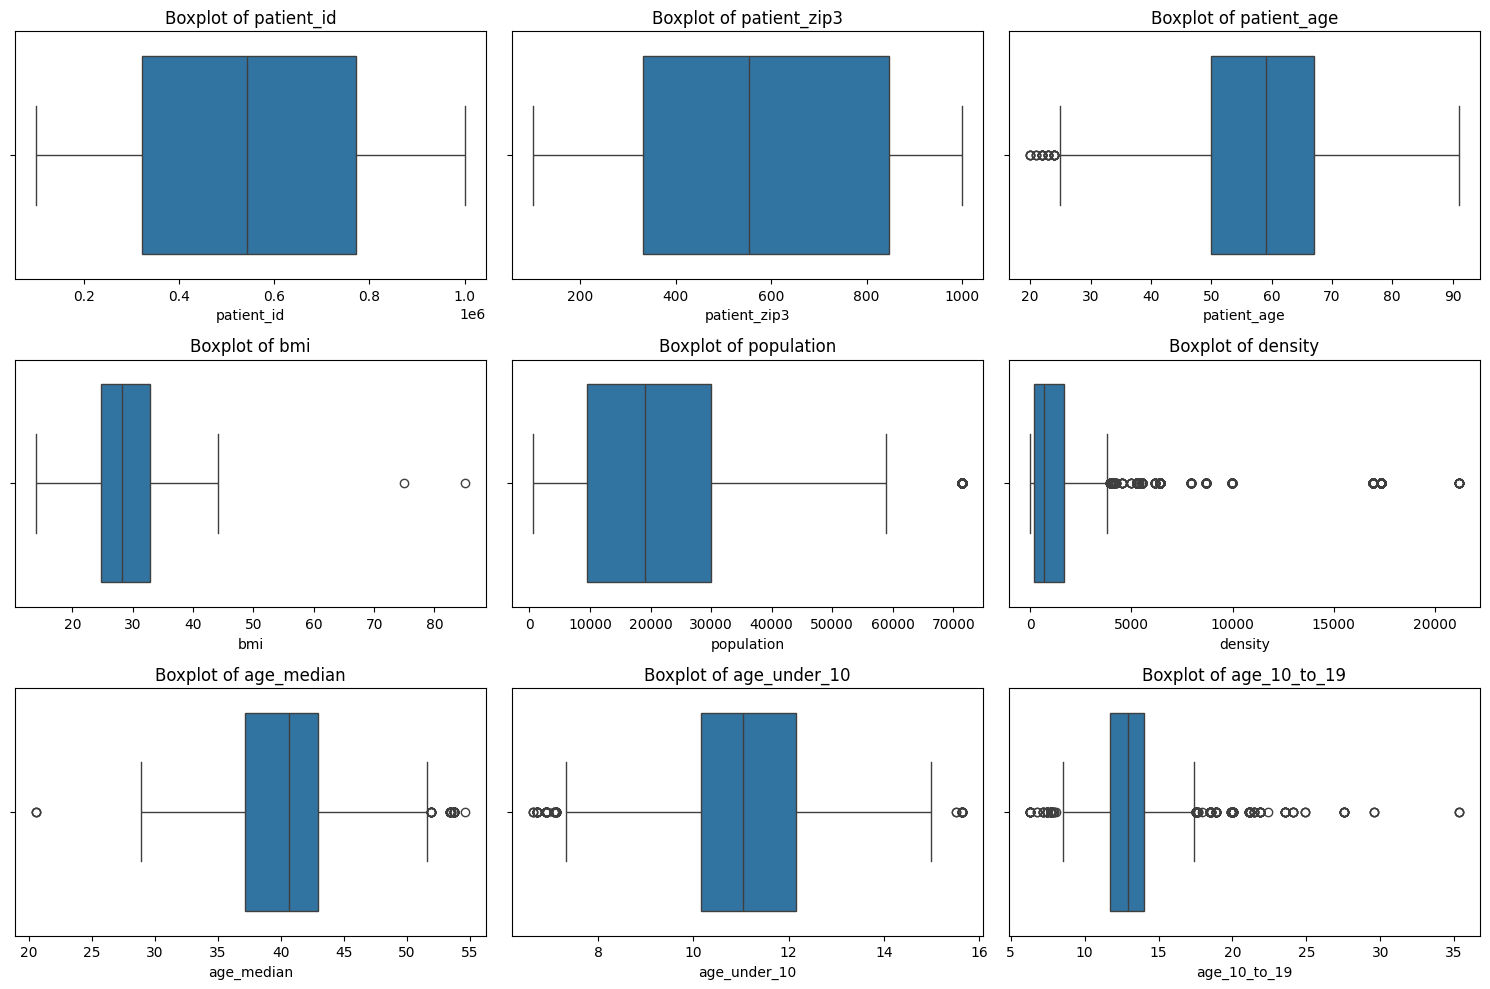

In [19]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:num_subplots], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=train_data[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show();

**SMOTE RESAMPLING**

In [91]:
X = train_data.drop('DiagPeriodL90D', axis=1)
y = train_data['DiagPeriodL90D']

from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
encoder = LabelEncoder()

# Encoding categorical variables in X
categorical_columns = X.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])

# Display the encoded X
X.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,475714,5,1,4,924,84,0,NaN,48,42,...,66.685714,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528
1,349367,4,0,4,928,62,0,28.49,29,12,...,37.948485,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179
2,138632,4,0,43,760,43,0,38.09,18,23,...,19.370000,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351
3,617843,4,0,4,926,45,0,NaN,22,4,...,16.716667,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123
4,817482,5,0,13,836,55,0,NaN,7,18,...,13.334000,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197


Here, we solved the problem of having null values with our data

**EDA**

In [93]:
X.shape

(12906, 82)

In [94]:
correlation_matrix=X.drop('patient_id',axis=1).select_dtypes(exclude='object').corr()
# only looking at correlations showing a coefficient higher than 0.01
corr_df = correlation_matrix[abs(correlation_matrix)>0.005].dropna(how='any',axis=0)
corr_df = correlation_matrix[abs(correlation_matrix)>0.005].dropna(how='any',axis=1)

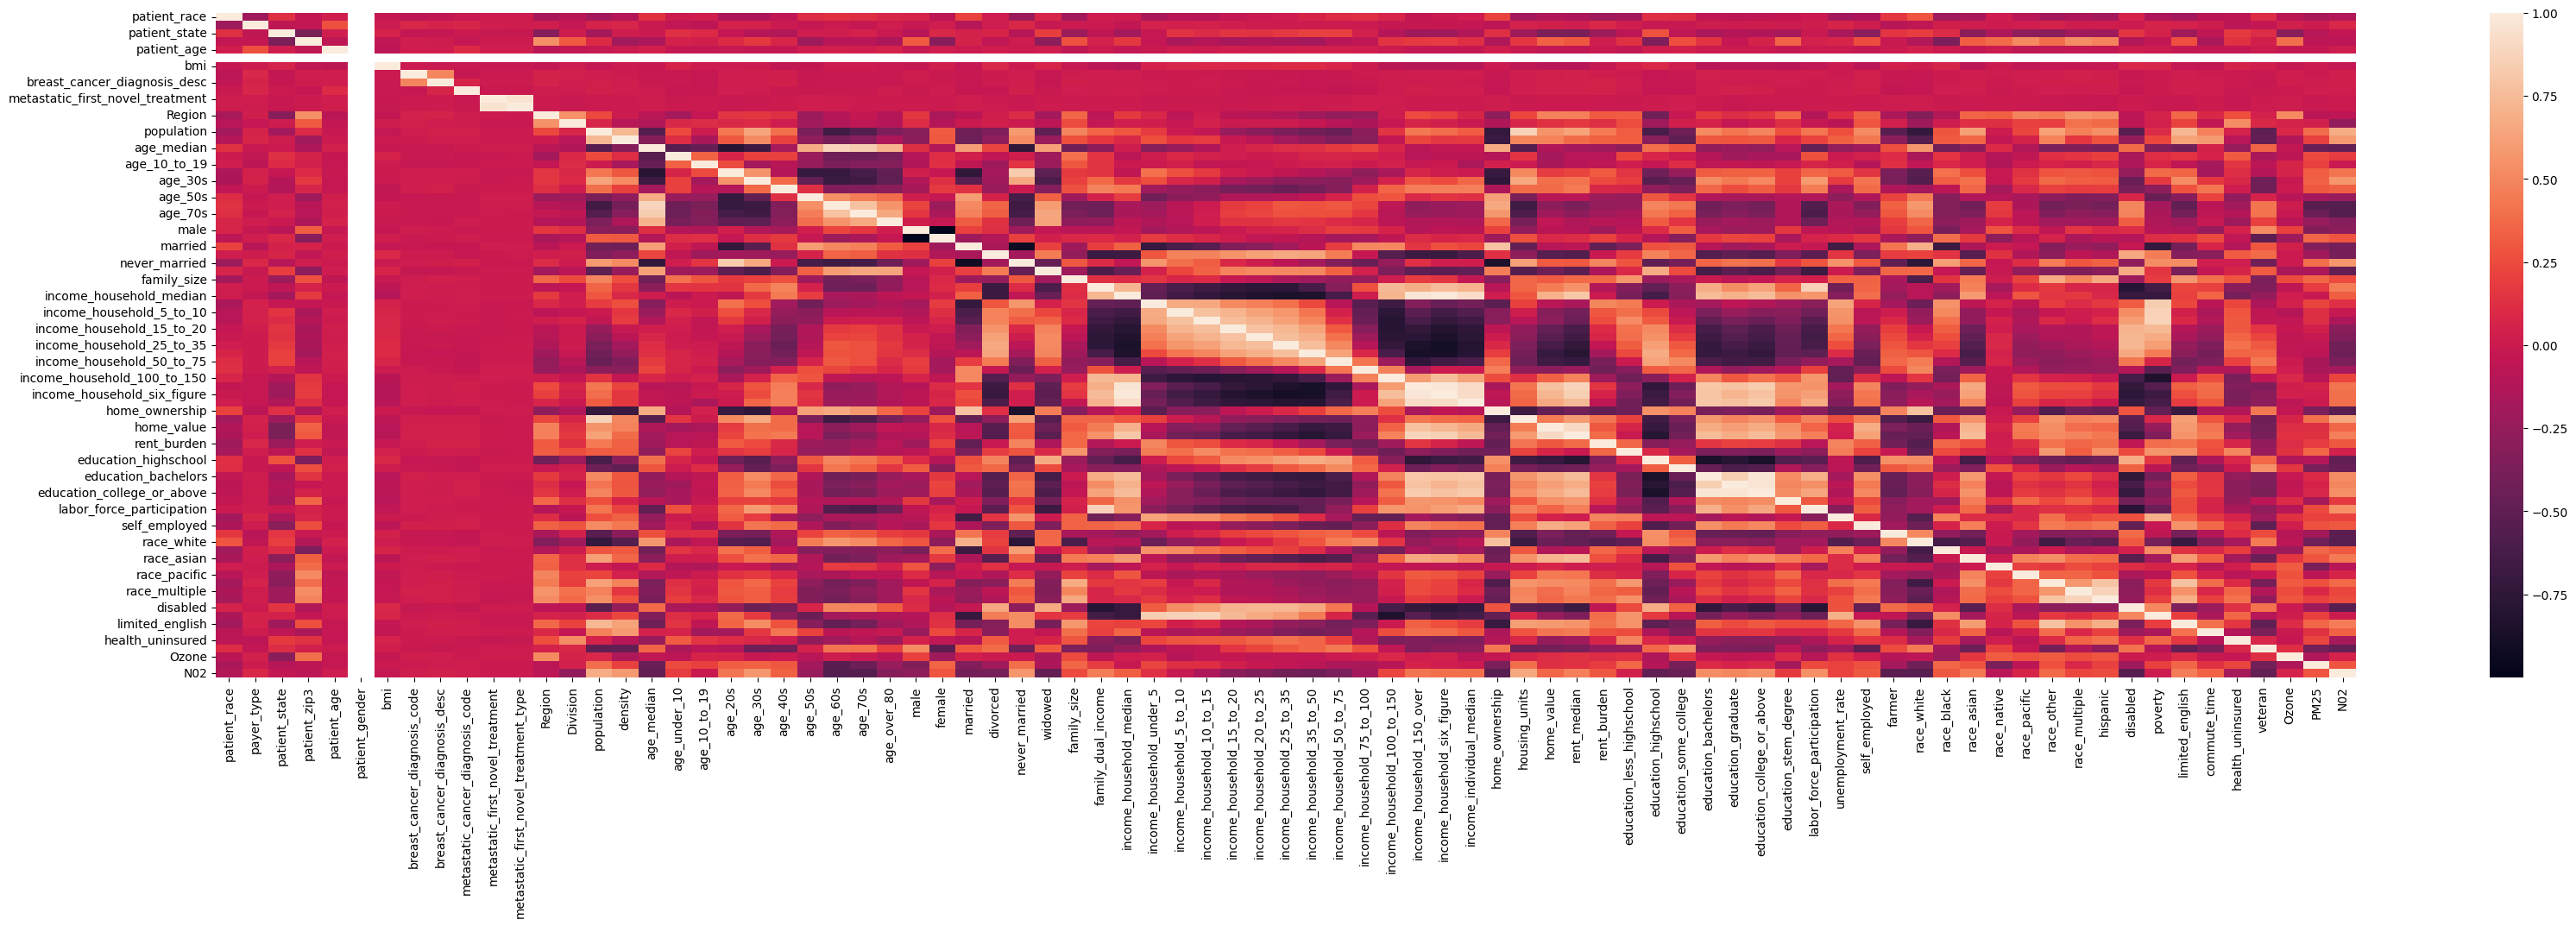

In [95]:
plt.figure(figsize=(40,10))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(correlation_matrix)
plt.show()

In [96]:
correlation_matrix

,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
patient_race,1.000000,-0.209853,0.130843,-0.042869,0.030259,NaN,-0.029907,-0.074569,-0.047815,-0.011606,...,-0.173202,0.056800,-0.143620,-0.193036,-0.085023,-0.064683,0.109766,-0.080770,-0.163496,-0.118027
payer_type,-0.209853,1.000000,-0.055070,-0.044254,0.267461,NaN,0.002128,0.081980,0.062163,0.073468,...,0.028139,-0.000506,0.055009,0.053750,0.013521,-0.073069,-0.040696,0.046493,0.007772,0.084314
patient_state,0.130843,-0.055070,1.000000,-0.371896,0.030600,NaN,0.060851,-0.039142,-0.026481,-0.002859,...,-0.212634,0.153375,0.052008,-0.211133,-0.060640,0.178443,0.111134,-0.305992,-0.097546,-0.039400
patient_zip3,-0.042869,-0.044254,-0.371896,1.000000,-0.060075,NaN,-0.048912,0.027595,0.015018,-0.024554,...,0.476728,-0.122086,-0.043850,0.262837,-0.158604,0.139937,0.038637,0.391243,-0.067037,-0.073708
patient_age,0.030259,0.267461,0.030600,-0.060075,1.000000,NaN,-0.062885,0.031021,0.031070,0.099953,...,-0.045538,0.014816,0.000200,-0.030850,-0.034765,-0.036971,0.001699,-0.025659,-0.023977,0.012902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
health_uninsured,-0.064683,-0.073069,0.178443,0.139937,-0.036971,NaN,0.061944,-0.005588,-0.002567,-0.015122,...,0.400933,0.129522,0.358342,0.160479,-0.107086,1.000000,0.080997,-0.029278,0.222733,-0.174115
veteran,0.109766,-0.040696,0.111134,0.038637,0.001699,NaN,0.027936,-0.007948,-0.017053,-0.012039,...,-0.266885,0.408566,-0.099426,-0.495338,-0.373883,0.080997,1.000000,0.122304,-0.408331,-0.479849
Ozone,-0.080770,0.046493,-0.305992,0.391243,-0.025659,NaN,-0.028554,0.030230,0.028740,-0.000549,...,0.285541,-0.004815,0.010937,0.109154,-0.015598,-0.029278,0.122304,1.000000,-0.136923,0.055694
PM25,-0.163496,0.007772,-0.097546,-0.067037,-0.023977,NaN,-0.000955,-0.001085,0.014331,0.026105,...,0.199955,-0.217333,0.199358,0.351605,0.137931,0.222733,-0.408331,-0.136923,1.000000,0.285042


**MODEL BUILDING**


In [97]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
#models to use
#instantiate the  models
r_f = RandomForestClassifier(random_state=42)
g_b = GradientBoostingClassifier()

Random Forest Model


The StandardScaler is a preprocessing technique used in machine learning to standardize the features by removing the mean and scaling them to unit variance

1. Normalization of Features
2. Improvement of Model Convergence
3. Effectiveness of Distance-Based Algorithms: Distance-based algorithms, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be sensitive to the scale of features.
4. Interpretability: Standardizing features does not change the relationship between features, so it does not affect the interpretability of the model. However, it can make the coefficients or feature importances easier to interpret because they are on the same scale.

In [107]:
# Initialize SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Handle missing values in X_train
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

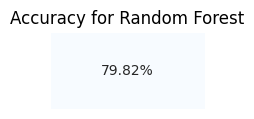

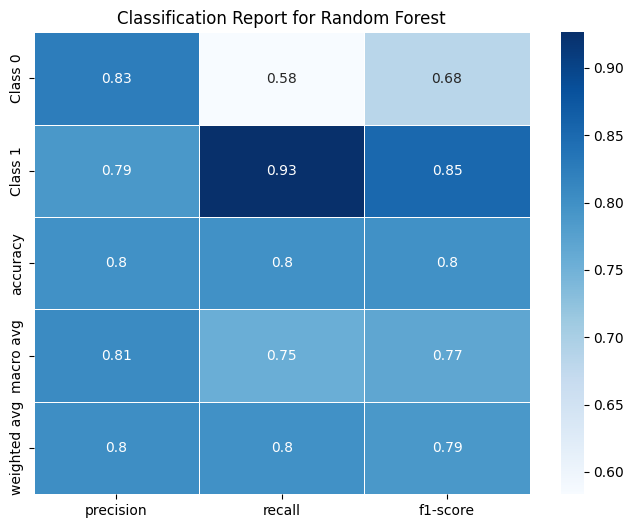

In [108]:
r_f.fit(X_train_scaled, y_train)
rf_pred = r_f.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[rf_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Random Forest')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(rf_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Random Forest')
plt.show()

KNN

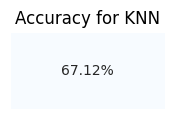

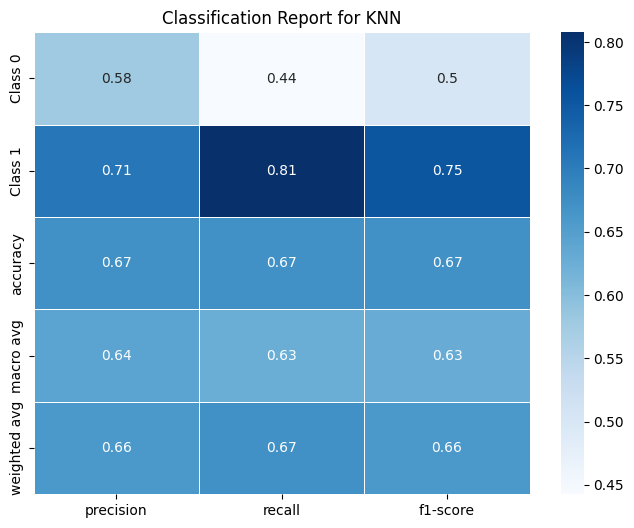

In [109]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)


knn_accuracy = accuracy_score(y_test, knn_pred)


knn_report = classification_report(y_test, knn_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[knn_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for KNN')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(knn_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for KNN')
plt.show()

SVM

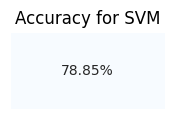

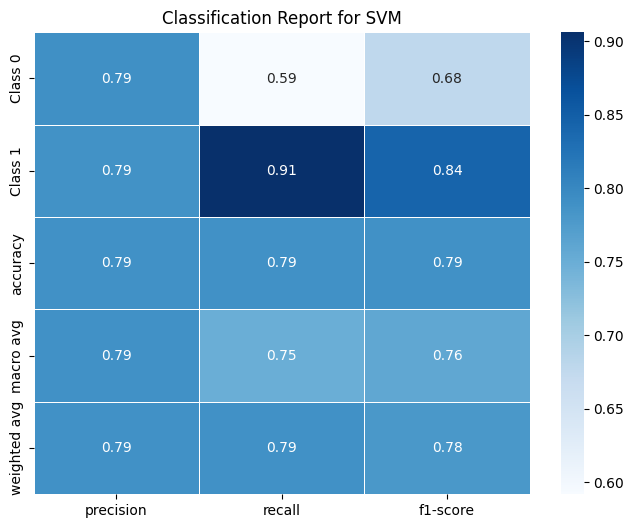

In [110]:
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

svm_accuracy = accuracy_score(y_test, svm_pred)


svm_report = classification_report(y_test, svm_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[svm_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for SVM')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(svm_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for SVM')
plt.show()

LOGISTIC REGRESSION

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


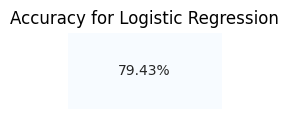

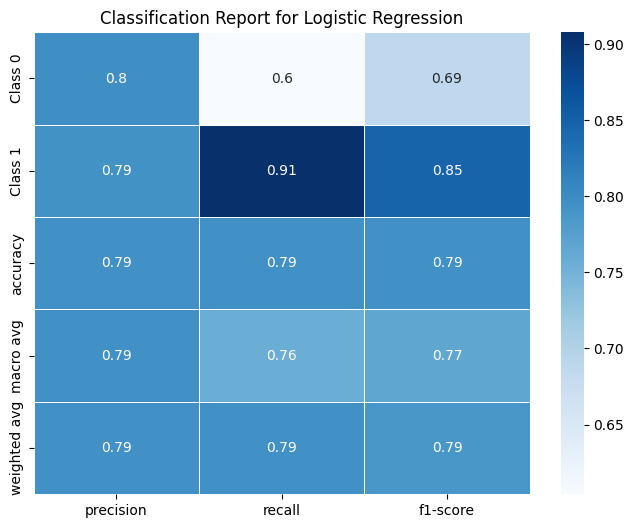

In [111]:
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_scaled, y_train)
logreg_pred = logreg_model.predict(X_test_scaled)


logreg_accuracy = accuracy_score(y_test, logreg_pred)


logreg_report = classification_report(y_test, logreg_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[logreg_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Logistic Regression')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(logreg_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Logistic Regression')
plt.show();

NAIVE BAYES

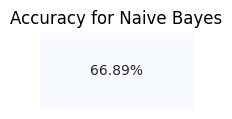

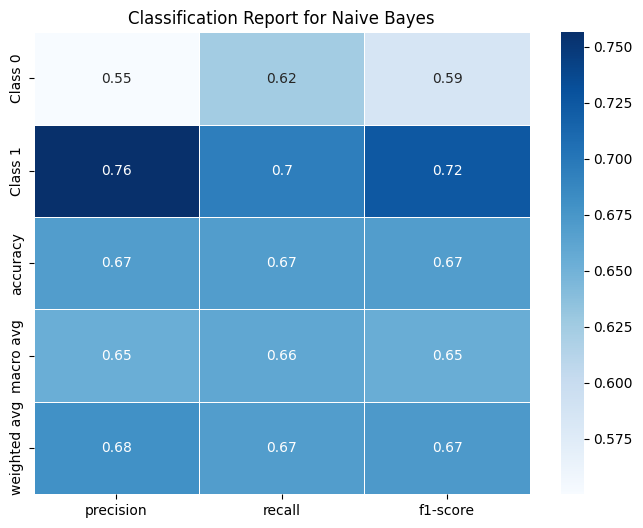

In [112]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_pred = nb_model.predict(X_test_scaled)


nb_accuracy = accuracy_score(y_test, nb_pred)


nb_report = classification_report(y_test, nb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[nb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Naive Bayes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(nb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Naive Bayes')
plt.show()

DECISION TREE CLASSIFIER MODEL

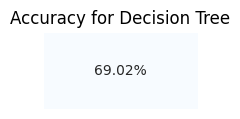

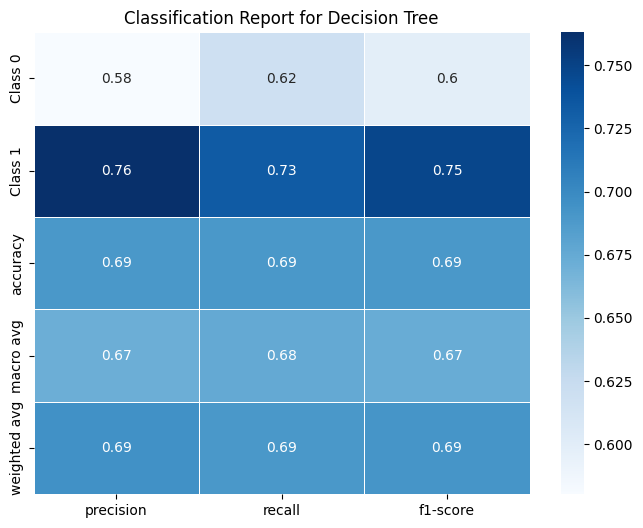

In [113]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)


dt_accuracy = accuracy_score(y_test, dt_pred)


dt_report = classification_report(y_test, dt_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
                                  

plt.figure(figsize=(2, 1))
sns.heatmap([[dt_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Decision Tree')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(dt_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Decision Tree')
plt.show()

GRADIENT BOOSTING MODEL

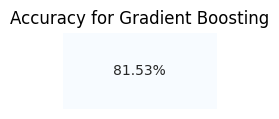

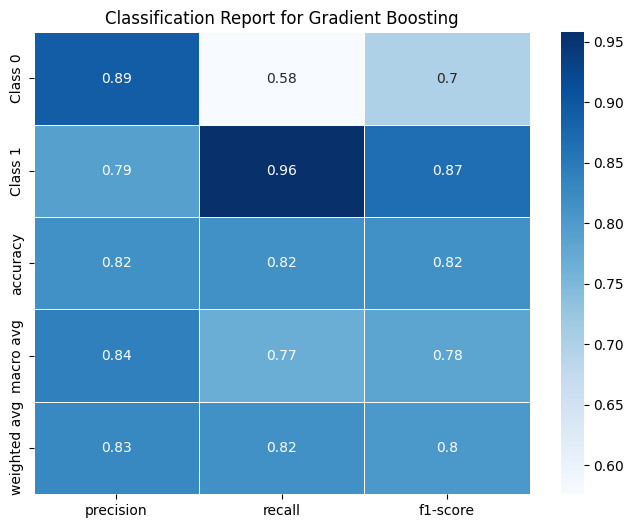

In [114]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)


gb_accuracy = accuracy_score(y_test, gb_pred)


gb_report = classification_report(y_test, gb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)


plt.figure(figsize=(2, 1))
sns.heatmap([[gb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for Gradient Boosting')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(gb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for Gradient Boosting')
plt.show();

XGBOOST MODEL

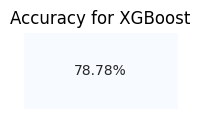

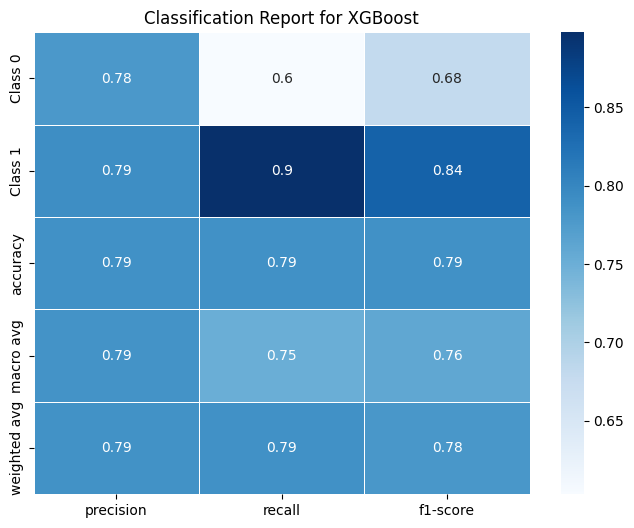

In [115]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)


xgb_accuracy = accuracy_score(y_test, xgb_pred)

xgb_report = classification_report(y_test, xgb_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

plt.figure(figsize=(2, 1))
sns.heatmap([[xgb_accuracy]], annot=True, fmt=".2%", cmap='Blues', cbar=False, linewidths=.5, xticklabels=False, yticklabels=False)
plt.title('Accuracy for XGBoost')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(xgb_report).iloc[:-1, :].T, annot=True, cmap='Blues', linewidths=.5)
plt.title('Classification Report for XGBoost')
plt.show()

Evident that RANDOMFORESTCLASSIFIER, LOGISTIC REG and GRADIENT BOOST have the highest Accuracy Score

Here's a breakdown of what this accuracy score signifies:

1. Accuracy: It's a measure of the overall correctness of the model's predictions.
2. High Accuracy: Indicates that your model is correct in its predictions for percentage of the samples in the test dataset.
3. 20% Misclassification Rate: Implies that the model incorrectly predicted the target variable for (100-percentage of high accuracy) of the samples in the test dataset.

In this challenge, I'll use the RandomForest and Gradientboost classifiers

In [116]:
# Generate predictions from base models using cross-validation
from sklearn.model_selection import cross_val_predict

rf_predictions = cross_val_predict(r_f, X_train_scaled, y_train, cv=5, method='predict_proba')
gb_predictions = cross_val_predict(gb_model, X_train_scaled, y_train, cv=5, method='predict_proba')


In [117]:
# Create new feature matrix for the meta-model using predictions from base models
X_meta = np.column_stack((rf_predictions[:, 1], gb_predictions[:, 1]))

In [118]:
meta_model = logreg_model

# Train the meta-model
meta_model.fit(X_meta, y_train)

LogisticRegression(random_state=42)

In [128]:
# Generate predictions from base models on the test set
X_test = test_data

# Handle missing values in X_test
X_test_imputed = imputer.fit_transform(X_test)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.fit_transform(X_test_imputed)

# Encoding categorical variables in X_test
categorical_columns = X_test.select_dtypes(include=['object']).columns
for col in categorical_columns:
    X_test[col] = encoder.fit_transform(X_test[col])


rf_test_predictions = r_f.predict_proba(X_test_scaled)
gb_test_predictions = gb_model.predict_proba(X_test_scaled)

# Create new feature matrix for the meta-model using predictions from base models on the test set
X_test_meta = np.column_stack((rf_test_predictions[:, 1], gb_test_predictions[:, 1]))

# Make predictions using the meta-model
prediction = meta_model.predict_proba(X_test_meta)

In [129]:
prediction_prob= prediction[:, 1]

In [130]:
prediction_prob.shape

(5792,)

In [131]:
submission_df = pd.DataFrame({'patient_id': X_test['patient_id'], 'DiagPeriodL90D': prediction_prob})
submission_df

,patient_id,DiagPeriodL90D
0,573710,0.796206
1,593679,0.794503
2,184532,0.775339
3,447383,0.790184
4,687972,0.823991
...,...,...
5787,977076,0.820342
5788,922960,0.839552
5789,759690,0.866626
5790,911717,0.089461
